## Calculate Mesozooplankton trophic level 

In [30]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

import cftime
import pandas as pd
import utils

import cmocean

In [31]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [32]:
## Campaign 2nd Cycle 
campaign_20yr = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim/GNG595_clim_1990-2009'
campaign_full = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595/ocn/hist/'
newNCDFfiles1 = sorted(glob(f'{campaign_20yr}_*.nc', recursive=True),
                      key=utils.numericalSort)

ds = xr.open_mfdataset(newNCDFfiles1,concat_dim='time', combine='nested')

In [33]:
mesozoo_names = { 'mesozoo_names': ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']}
zn = pd.DataFrame(data=mesozoo_names)

phyto_names = { 'phyto_names': ['pp','mp1','diaz','mp2','diat1','diat2','mp3','diat3','mp4']}
pn = pd.DataFrame(data=phyto_names)

## Get plankton size information from file.

In [34]:
## Gaby's Path 
gabyn_path = '/glade/work/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')

sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


In [35]:
prey_varnames = {}
for i,v in enumerate(sizes.sname):
    prey_varnames[v]=i

In [36]:
pred_varnames = {'zoo1':0,'zoo2':1,'zoo3':2,'zoo4':3,'zoo5':4,'zoo6':5}
grazing_vars = [v for v in ds if 'graze' in v and 'zint' not in v]

In [37]:
graze_split = [v.split('_',3) for v in grazing_vars]
graze_split = pd.DataFrame(graze_split)
graze_split = graze_split.rename({0:'var',1:'prey',2:'pred'}, axis=1)
graze_split['var'] = grazing_vars

In [38]:
variables = [v for v in ds if 'graze' in v and 'zint' not in v]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [45]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

variables = [f'{var}' for var in ['graze_diaz_zoo1','graze_diaz_zoo2',
                                  'graze_pp_zoo1',
                                  'graze_mp1_zoo1','graze_mp1_zoo2',
                                  'graze_mp2_zoo2','graze_mp2_zoo3',
                                  'graze_mp3_zoo3','graze_mp3_zoo4',
                                  'graze_mp4_zoo4','graze_mp4_zoo5',
                                  'graze_diat1_zoo1','graze_diat1_zoo2','graze_diat1_zoo3','graze_diat1_zoo4',
                                  'graze_diat2_zoo2','graze_diat2_zoo3','graze_diat2_zoo4',
                                  'graze_diat3_zoo3','graze_diat3_zoo4','graze_diat3_zoo5',
                                  'graze_zoo1_zoo2',
                                  'graze_zoo1_zoo3',
                                  'graze_zoo2_zoo3',
                                  'graze_zoo2_zoo4',
                                  'graze_zoo3_zoo4',
                                  'graze_zoo3_zoo5',
                                  'graze_zoo4_zoo5',
                                  'graze_zoo4_zoo6',
                                  'graze_zoo5_zoo6',
                                 ]]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [46]:
%%time

ds_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_annual = xr.Dataset()

    file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    dsv_annual=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_annual = xr.merge((ds_annual, dsv_annual[vv]))
        

    ds_annual = ds_annual.drop([v for v in ds_annual.variables if v not in keep_vars]).squeeze()
    ds_avg = xr.concat([ds_avg, ds_annual],dim='year',data_vars="different",join="override")

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 10min 21s, sys: 5min 9s, total: 15min 30s
Wall time: 19min 33s


## Get a cluster so it can continue running without interruptions

In [47]:
ds_avg

,Array,Chunk
Bytes,5.11 GiB,10.65 MiB
Shape,"(62, 12, 15, 384, 320)","(2, 1, 15, 305, 305)"
Count,1682 Graph Layers,2928 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.11 GiB,10.65 MiB
Shape,"(62, 12, 15, 384, 320)","(2, 1, 15, 305, 305)"
Count,1682 Graph Layers,2928 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [50]:
# set trophic level for phyto = 1
tmpOnes = np.ones(shape=ds_avg.graze_diaz_zoo2.shape)
tlvals = {}
for v in pn.phyto_names:
    tlvals[v]=tmpOnes

# set trophic level for zoo = NaN initially
tmp = tmpOnes.copy()
tmp[:] = np.nan
for v in zn.mesozoo_names:
    tlvals[v]=tmp
    
zoo = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']

In [51]:
ds_avg

,Array,Chunk
Bytes,5.11 GiB,10.65 MiB
Shape,"(62, 12, 15, 384, 320)","(2, 1, 15, 305, 305)"
Count,1682 Graph Layers,2928 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.11 GiB,10.65 MiB
Shape,"(62, 12, 15, 384, 320)","(2, 1, 15, 305, 305)"
Count,1682 Graph Layers,2928 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [52]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [53]:
prey_varnames = {}
for i,v in enumerate(sizes.sname):
    prey_varnames[v]=i

In [54]:
pred_varnames = {'zoo3':2,'zoo4':3,'zoo5':4,'zoo6':5}
grazing_vars = [v for v in ds if 'graze' in v and 'zint' not in v]

In [55]:
grazing_vars

['graze_diaz_zoo1',
 'graze_diaz_zoo2',
 'graze_diaz_zoo3',
 'graze_pp_zoo1',
 'graze_mp1_zoo1',
 'graze_mp1_zoo2',
 'graze_mp2_zoo2',
 'graze_mp2_zoo3',
 'graze_mp2_zoo4',
 'graze_mp3_zoo3',
 'graze_mp3_zoo4',
 'graze_mp3_zoo5',
 'graze_mp4_zoo4',
 'graze_mp4_zoo5',
 'graze_mp4_zoo6',
 'graze_diat1_zoo1',
 'graze_diat1_zoo2',
 'graze_diat1_zoo3',
 'graze_diat1_zoo4',
 'graze_diat2_zoo2',
 'graze_diat2_zoo3',
 'graze_diat2_zoo4',
 'graze_diat2_zoo5',
 'graze_diat3_zoo3',
 'graze_diat3_zoo4',
 'graze_diat3_zoo5',
 'graze_diat3_zoo6',
 'graze_zoo1_zoo2',
 'graze_zoo1_zoo3',
 'graze_zoo2_zoo3',
 'graze_zoo2_zoo4',
 'graze_zoo3_zoo4',
 'graze_zoo3_zoo5',
 'graze_zoo4_zoo5',
 'graze_zoo4_zoo6',
 'graze_zoo5_zoo6']

In [56]:
%%time
for i,vs in enumerate(zn.mesozoo_names):
    
    # pull out the appropriate grazing variables in the history file
    graze_vars = [v for v in ds_avg if re.match('graze_(.*)_'+vs,v)]
    
    # holder for the grazing values
    shape = ds_avg[graze_vars[0]].shape + (len(graze_vars),)

    graze_vals = np.empty(shape=shape)
    graze_tl = np.ones(shape=shape)
    
    for gi,gv in enumerate(graze_vars):
        
        # pull out identity of prey
        g,prey,pred = gv.split('_',3)
        print(prey,pred)
        
        # if prey is zooplankton, then apply alternate trophic level
        if prey in zoo:
            graze_tl[...,gi]=tlvals[prey]
        
        graze_vals[...,gi] = ds_avg[gv].values # Ellipses select the last slice
    # graze_vals*grazetl/graze_vals    
    tlvals[vs] = 1 + (np.sum(graze_vals * graze_tl, axis=-1) / np.sum(graze_vals, axis=-1)) # axis=-1 means sum over the last axis

diaz zoo1
pp zoo1
mp1 zoo1
diat1 zoo1
diaz zoo2
mp1 zoo2
mp2 zoo2
diat1 zoo2
diat2 zoo2
zoo1 zoo2
mp2 zoo3
mp3 zoo3
diat1 zoo3
diat2 zoo3
diat3 zoo3
zoo1 zoo3
zoo2 zoo3
mp3 zoo4
mp4 zoo4
diat1 zoo4
diat2 zoo4
diat3 zoo4
zoo2 zoo4
zoo3 zoo4
mp4 zoo5
diat3 zoo5
zoo3 zoo5
zoo4 zoo5
zoo4 zoo6
zoo5 zoo6
CPU times: user 20min 28s, sys: 45min 25s, total: 1h 5min 53s
Wall time: 3h 21min 32s


In [63]:
tlvals['zoo3'].shape

(62, 12, 15, 384, 320)

In [65]:
ds_avg.z_t_150m

<xarray.DataArray 'z_t_150m' (z_t_150m: 15)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
Dimensions without coordinates: z_t_150m

%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/tlvals_62yr.npy", tlvals)

In [68]:
%%time
zoods = xr.DataArray(tlvals['zoo3'], coords={'year':ds_avg.year, 'time':ds_avg.time,'z_t_150m':ds_avg.z_t_150m, 'nlat':ds_avg.nlat, 'nlon':ds_avg.nlon},
                      dims=['year', 'time', 'z_t_150m','nlat', 'nlon'])
zoods = zoods.to_dataset(name='zoo3TL')

zoods['zoo4TL'] = xr.DataArray(tlvals['zoo4'], coords={'year':ds_avg.year, 'time':ds_avg.time,'z_t_150m':ds_avg.z_t_150m, 'nlat':ds_avg.nlat, 'nlon':ds_avg.nlon},
                      dims=['year', 'time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo5TL'] = xr.DataArray(tlvals['zoo5'], coords={'year':ds_avg.year, 'time':ds_avg.time,'z_t_150m':ds_avg.z_t_150m, 'nlat':ds_avg.nlat, 'nlon':ds_avg.nlon},
                      dims=['year',  'time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo6TL'] = xr.DataArray(tlvals['zoo6'], coords={'year':ds_avg.year, 'time':ds_avg.time,'z_t_150m':ds_avg.z_t_150m, 'nlat':ds_avg.nlat, 'nlon':ds_avg.nlon},
                      dims=['year', 'time', 'z_t_150m', 'nlat', 'nlon'])

CPU times: user 9.74 ms, sys: 0 ns, total: 9.74 ms
Wall time: 11.5 ms


In [73]:
zoods['zoo1TL'] = xr.DataArray(tlvals['zoo1'], coords={'year':ds_avg.year, 'time':ds_avg.time,'z_t_150m':ds_avg.z_t_150m, 'nlat':ds_avg.nlat, 'nlon':ds_avg.nlon},
                      dims=['year',  'time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo2TL'] = xr.DataArray(tlvals['zoo2'], coords={'year':ds_avg.year, 'time':ds_avg.time,'z_t_150m':ds_avg.z_t_150m, 'nlat':ds_avg.nlat, 'nlon':ds_avg.nlon},
                      dims=['year', 'time', 'z_t_150m', 'nlat', 'nlon'])

In [69]:
%%time
zoods['zooTL_g'] = xr.concat([zoods[v+'TL'] for v in ['zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')

CPU times: user 53.3 s, sys: 1min 3s, total: 1min 57s
Wall time: 2min 8s


In [77]:
%%time
zoods['zooTL_all'] = xr.concat([zoods[v+'TL'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')

CPU times: user 1min 36s, sys: 3min 18s, total: 4min 55s
Wall time: 20min 18s


In [78]:
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/zoo_TL_62yr.npy", zoods.zooTL_all)

In [71]:
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/mesozoo_TL_62yr.npy", zoods.zooTL_g)

In [72]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/zoo3TL_62yr.npy", zoods.zoo3TL)
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/zoo4TL_62yr.npy", zoods.zoo4TL)
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/zoo5TL_62yr.npy", zoods.zoo5TL)
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/zoo6TL_62yr.npy", zoods.zoo6TL)

CPU times: user 0 ns, sys: 29 s, total: 29 s
Wall time: 38.9 s


In [79]:
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pop_tools

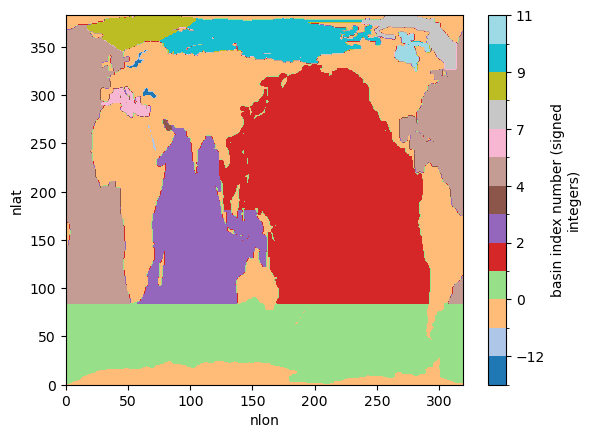

In [80]:
grid_name = 'POP_gx1v7'

dz = pop_tools.get_grid(grid_name)
regions = np.array(np.unique(dz.REGION_MASK))
regions
dz.REGION_MASK.plot.contourf(levels=regions, cmap='tab20');

In [81]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

In [82]:
AO   = np.where(mask3d.sel(region='Arctic Ocean').values==1)

In [92]:
zooTL_all = np.nanmean(zoods['zooTL_all'],axis=(0,2))

In [96]:
zoo_TL_try1= np.load("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/zoo_TL_62yr.npy")

In [98]:
zoo_TL_1 = np.nanmean(zoo_TL_try1,axis=(0,2))

In [99]:
zoo_TL_1[:,AO[0],AO[1]].shape

(12, 5068)

In [100]:
TL_AO = np.nanmean(zoo_TL_1[:,AO[0],AO[1]],axis=(1))

Text(0.03, 0.5, 'Zooplankton Trophic Level')

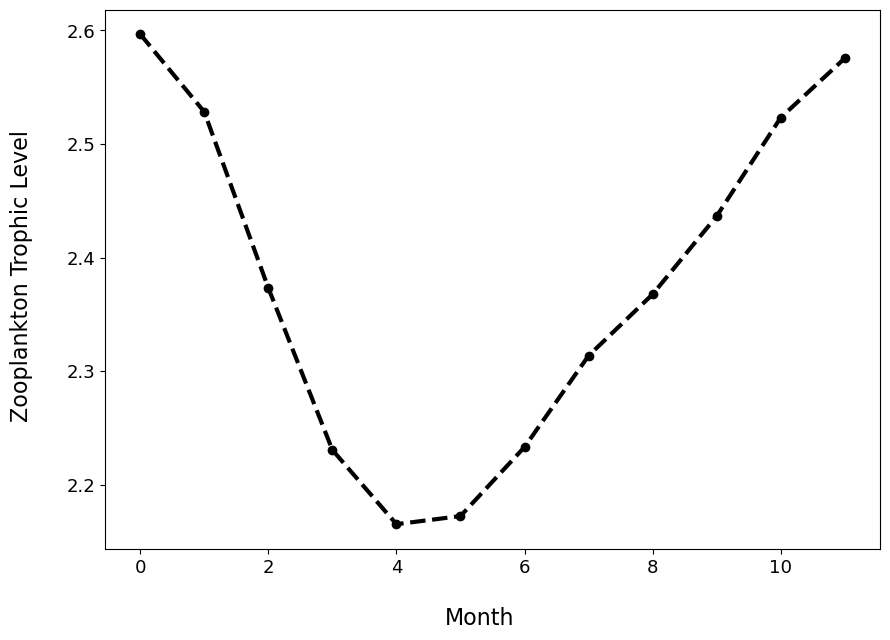

In [101]:
fig = plt.figure(figsize=(10, 7))
sfont=13
font=16

#subplot 1
months = np.arange(0,12)
ax1 = fig.add_subplot(1, 1, 1)
lnsp1 = ax1.plot(months,TL_AO, '--o', color='k',linewidth=3,label='Zooplankton TL');
ax1.tick_params(axis='both',labelsize=sfont);

fig.text(0.5, 0.001, 'Month', ha='center',fontsize=font)
fig.text(0.03, 0.5, 'Zooplankton Trophic Level', va='center', rotation='vertical',fontsize=font)

Text(0.03, 0.5, 'Zooplankton Trophic Level')

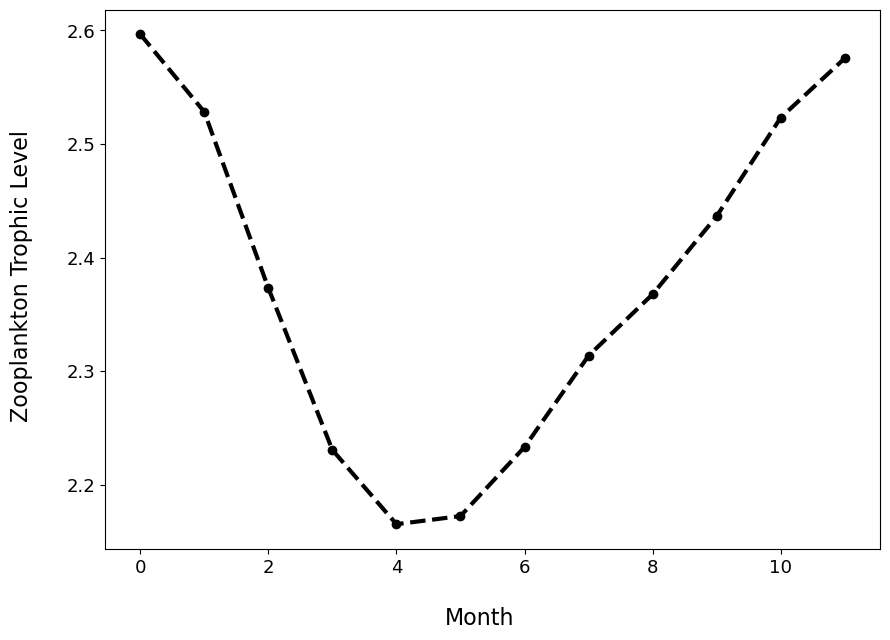

In [95]:
fig = plt.figure(figsize=(10, 7))
sfont=13
font=16

#subplot 1
months = np.arange(0,12)
ax1 = fig.add_subplot(1, 1, 1)
lnsp1 = ax1.plot(months,TL_AO, '--o', color='k',linewidth=3,label='Zooplankton TL');
ax1.tick_params(axis='both',labelsize=sfont);

fig.text(0.5, 0.001, 'Month', ha='center',fontsize=font)
fig.text(0.03, 0.5, 'Zooplankton Trophic Level', va='center', rotation='vertical',fontsize=font)